In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Neuron Parameters ---
C_m = 1.0       # Membrane capacitance (uF/cm^2)
g_L = 0.1       # Leak conductance (mS/cm^2)
E_L = -70.0     # Resting/leak potential (mV)
V_th = -50.0    # Spike threshold (mV)
V_reset = -65.0 # Reset potential (mV)
V_spike = 20.0  # Artificial spike peak for visualization (mV)
t_ref = 2.0     # Absolute refractory period (ms)

# --- Simulation Setup ---
dt = 0.1        # Integration time step (ms)
T = 150.0       # Total simulation time (ms)
time = np.arange(0, T, dt)

# --- Stimulus (External Current) ---
# We'll use a step current: 
# - Baseline (subthreshold)
# - Strong pulse (suprathreshold)
# - Return to baseline
I_ext = np.zeros_like(time)
I_ext[(time >= 20) & (time < 50)] = 1.5   # Weak input: subthreshold integration
I_ext[(time >= 70) & (time < 130)] = 3.0  # Strong input: sustained firing

In [2]:
# --- State Variables ---
V_m = np.zeros_like(time)
V_m[0] = E_L
spikes = []       # Store spike times
t_rest = 0.0      # Refractory timer

# --- Euler Integration Loop ---
for i in range(1, len(time)):
    # If the neuron is in its refractory period, clamp the voltage
    if t_rest > 0:
        V_m[i] = V_reset
        t_rest -= dt
    else:
        # Differential equation: C * dV/dt = -g_L(V - E_L) + I
        dV = (-g_L * (V_m[i-1] - E_L) + I_ext[i-1]) / C_m
        V_m[i] = V_m[i-1] + dV * dt
        
        # Check for threshold crossing
        if V_m[i] >= V_th:
            spikes.append(time[i])
            V_m[i-1] = V_spike  # Overwrite previous step with a peak for a pretty plot
            V_m[i] = V_reset    # Reset current step
            t_rest = t_ref      # Trigger refractory period

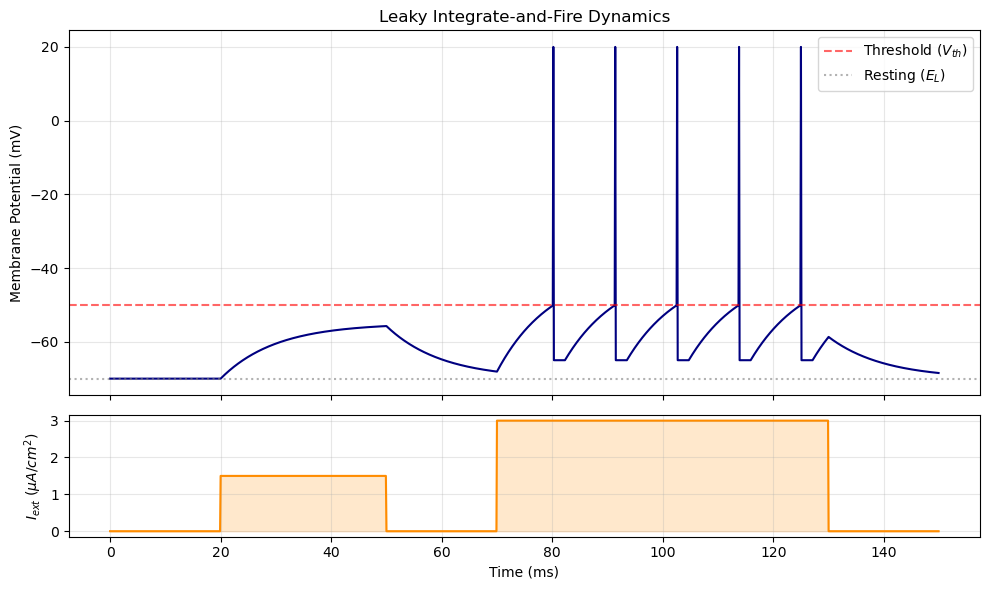

Total spikes fired: 5
Spike times (ms): [ 80.3  91.5 102.7 113.9 125.1]


In [3]:
# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot Membrane Potential
ax1.plot(time, V_m, color='navy', lw=1.5)
ax1.axhline(V_th, color='red', linestyle='--', alpha=0.6, label='Threshold ($V_{th}$)')
ax1.axhline(E_L, color='gray', linestyle=':', alpha=0.6, label='Resting ($E_L$)')
ax1.set_ylabel('Membrane Potential (mV)')
ax1.set_title('Leaky Integrate-and-Fire Dynamics')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot Injected Current
ax2.plot(time, I_ext, color='darkorange', lw=1.5)
ax2.set_ylabel('$I_{ext}$ ($\mu A/cm^2$)')
ax2.set_xlabel('Time (ms)')
ax2.fill_between(time, 0, I_ext, color='darkorange', alpha=0.2)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total spikes fired: {len(spikes)}")
print(f"Spike times (ms): {np.round(spikes, 1)}")

In [4]:
# --- Network & Neuron Parameters ---
N = 10                  # Number of neurons
C_m = 1.0               # Membrane capacitance (uF/cm^2)
g_L = 0.1               # Leak conductance (mS/cm^2)
E_L = -70.0             # Resting/leak potential (mV)
V_th = -50.0            # Spike threshold (mV)
V_reset = -65.0         # Reset potential (mV)
t_ref = 2.0             # Absolute refractory period (ms)

# --- Simulation Setup ---
dt = 0.1                # Integration time step (ms)
T = 200.0               # Total simulation time (ms)
time = np.arange(0, T, dt)
n_steps = len(time)

# --- Stimulus (Heterogeneous External Current) ---
# We'll apply a step current that turns on at t=20ms and off at t=160ms.
# To see different firing rates, each neuron gets a linearly increasing amount of current.
I_base = np.zeros((N, n_steps))
stim_window = (time >= 20) & (time < 160)

# Neuron 0 gets 0.5 uA, Neuron 9 gets ~4.0 uA
current_amplitudes = np.linspace(0.5, 4.0, N) 

for i in range(N):
    I_base[i, stim_window] = current_amplitudes[i]

In [5]:
# --- State Variables ---
# V_m matrix: rows = neurons, columns = time steps
V_m = np.zeros((N, n_steps))
V_m[:, 0] = E_L + np.random.randn(N) * 2  # Add tiny noise to initial conditions

# To track spikes for a raster plot, we'll store lists of spike times for each neuron
spike_times = [[] for _ in range(N)]

# Vector to track the remaining refractory time for each neuron
t_rest = np.zeros(N)

# --- Vectorized Euler Integration ---
for t_idx in range(1, n_steps):
    # 1. Identify which neurons are currently refractory
    refractory_mask = t_rest > 0
    active_mask = ~refractory_mask
    
    # 2. Update refractory timers
    t_rest[refractory_mask] -= dt
    
    # 3. Clamp voltage for refractory neurons
    V_m[refractory_mask, t_idx] = V_reset
    
    # 4. Integrate voltage for active neurons
    # Only calculate dV for neurons that are not in their refractory period
    V_prev = V_m[active_mask, t_idx-1]
    I_in = I_base[active_mask, t_idx-1]
    
    dV = (-g_L * (V_prev - E_L) + I_in) / C_m
    V_m[active_mask, t_idx] = V_prev + dV * dt
    
    # 5. Check for spikes across all active neurons
    # Find indices of active neurons that crossed the threshold
    spiked_active_indices = np.where(V_m[active_mask, t_idx] >= V_th)[0]
    
    # Map back to the absolute neuron indices (0 to N-1)
    # np.where(active_mask)[0] gives the absolute indices of the active neurons
    absolute_spiked_indices = np.where(active_mask)[0][spiked_active_indices]
    
    # 6. Process the spikes
    for spike_idx in absolute_spiked_indices:
        spike_times[spike_idx].append(time[t_idx])
        V_m[spike_idx, t_idx-1] = 20.0  # Artificial peak for visualization
        V_m[spike_idx, t_idx] = V_reset # Reset voltage
        t_rest[spike_idx] = t_ref       # Trigger refractory period

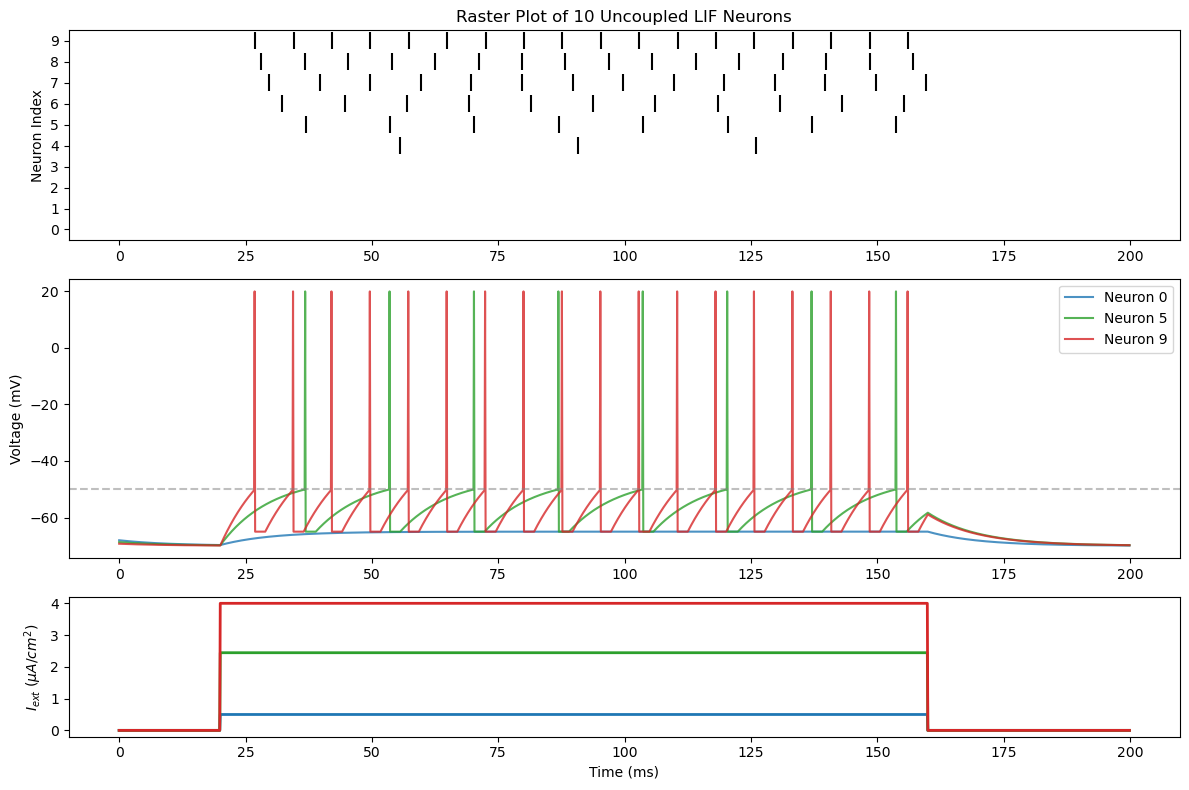

In [6]:
# --- Plotting ---
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(3, 1, height_ratios=[1.5, 2, 1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# 1. Raster Plot (Population Spiking Activity)
for i in range(N):
    ax1.vlines(spike_times[i], i + 0.6, i + 1.4, color='black', lw=1.5)
ax1.set_ylabel('Neuron Index')
ax1.set_yticks(np.arange(1, N + 1))
ax1.set_yticklabels(np.arange(0, N))
ax1.set_title(f'Raster Plot of {N} Uncoupled LIF Neurons')
ax1.set_ylim(0.5, N + 0.5)

# 2. Voltage Traces (Show just the first, middle, and last neuron)
colors = ['#1f77b4', '#2ca02c', '#d62728']
for idx, color in zip([0, N//2, N-1], colors):
    ax2.plot(time, V_m[idx, :], label=f'Neuron {idx}', color=color, alpha=0.8)
ax2.axhline(V_th, color='gray', linestyle='--', alpha=0.5)
ax2.set_ylabel('Voltage (mV)')
ax2.legend(loc='upper right')

# 3. Input Currents (Show the corresponding currents)
for idx, color in zip([0, N//2, N-1], colors):
    ax3.plot(time, I_base[idx, :], color=color, lw=2)
ax3.set_ylabel('$I_{ext}$ ($\mu A/cm^2$)')
ax3.set_xlabel('Time (ms)')

plt.tight_layout()
plt.show()

In [7]:
# --- Network & Neuron Parameters ---
N = 100                 # Increased N to calculate a meaningful spatial average for A(t)
C_m = 1.0               
g_L = 0.1               
E_L = -70.0             
V_th = -50.0            
V_reset = -65.0         
t_ref = 2.0             

# --- Noise Parameter ---
sigma = 5.0             # Noise amplitude (sigma)

# --- Simulation Setup ---
dt = 0.1                
T = 200.0               
time = np.arange(0, T, dt)
n_steps = len(time)

# --- Stimulus ---
# We'll apply a constant subthreshold base current to all neurons.
# The noise will be the primary driver pushing neurons over the threshold.
I_base = np.ones((N, n_steps)) * 1.5

In [8]:
# --- State Variables ---
V_m = np.zeros((N, n_steps))
V_m[:, 0] = E_L + np.random.randn(N) * 2  

spike_times = [[] for _ in range(N)]
t_rest = np.zeros(N)

# Array to store the population activity A(t)
A_t = np.zeros(n_steps)

# --- Vectorized Euler Integration ---
for t_idx in range(1, n_steps):
    refractory_mask = t_rest > 0
    active_mask = ~refractory_mask
    
    t_rest[refractory_mask] -= dt
    V_m[refractory_mask, t_idx] = V_reset
    
    num_active = np.sum(active_mask)
    if num_active > 0:
        V_prev = V_m[active_mask, t_idx-1]
        I_in = I_base[active_mask, t_idx-1]
        
        # Add the fluctuating input xi(t) which is normally distributed with mean zero
        xi = np.random.randn(num_active)
        
        # dV includes the deterministic components + noise term
        dV = (-g_L * (V_prev - E_L) + I_in + sigma * xi) / C_m
        V_m[active_mask, t_idx] = V_prev + dV * dt
    
    spiked_active_indices = np.where(V_m[active_mask, t_idx] >= V_th)[0]
    absolute_spiked_indices = np.where(active_mask)[0][spiked_active_indices]
    
    # Calculate population activity A(t) = n_sp / (N * dt)
    n_sp = len(absolute_spiked_indices)
    A_t[t_idx] = n_sp / (N * dt)
    
    for spike_idx in absolute_spiked_indices:
        spike_times[spike_idx].append(time[t_idx])
        V_m[spike_idx, t_idx-1] = 20.0  
        V_m[spike_idx, t_idx] = V_reset 
        t_rest[spike_idx] = t_ref

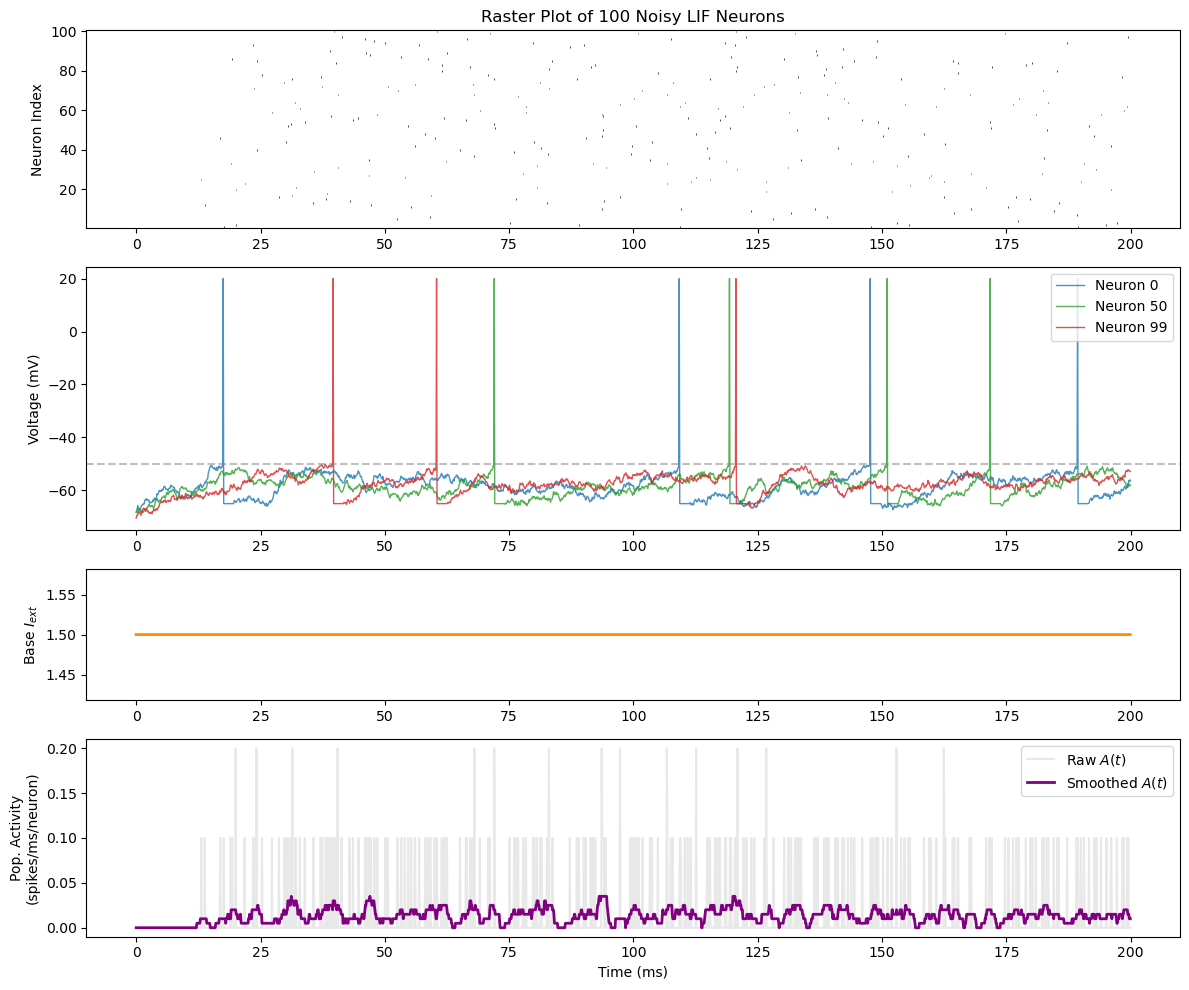

In [9]:
# --- Plotting ---
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(4, 1, height_ratios=[1.5, 2, 1, 1.5])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)
ax4 = fig.add_subplot(gs[3], sharex=ax1)

# 1. Raster Plot
for i in range(N):
    if len(spike_times[i]) > 0:
        ax1.vlines(spike_times[i], i + 0.6, i + 1.4, color='black', lw=0.5)
ax1.set_ylabel('Neuron Index')
ax1.set_title(f'Raster Plot of {N} Noisy LIF Neurons')
ax1.set_ylim(0.5, N + 0.5)

# 2. Voltage Traces (Show 3 random neurons)
colors = ['#1f77b4', '#2ca02c', '#d62728']
for idx, color in zip([0, N//2, N-1], colors):
    ax2.plot(time, V_m[idx, :], label=f'Neuron {idx}', color=color, alpha=0.8, lw=1)
ax2.axhline(V_th, color='gray', linestyle='--', alpha=0.5)
ax2.set_ylabel('Voltage (mV)')
ax2.legend(loc='upper right')

# 3. Input Current (Deterministic baseline)
ax3.plot(time, I_base[0, :], color='darkorange', lw=2)
ax3.set_ylabel('Base $I_{ext}$')

# 4. Population Activity A(t)
# Applying a simple moving average to smooth the heavily fluctuating discrete rate
window_size = 20
A_t_smooth = np.convolve(A_t, np.ones(window_size)/window_size, mode='same')

ax4.plot(time, A_t, color='lightgray', alpha=0.5, label='Raw $A(t)$')
ax4.plot(time, A_t_smooth, color='purple', lw=2, label='Smoothed $A(t)$')
ax4.set_ylabel('Pop. Activity\n(spikes/ms/neuron)')
ax4.set_xlabel('Time (ms)')
ax4.legend(loc='upper right')

plt.tight_layout()
plt.show()